In [1]:
# import packages 
import numpy as np 
import h5py
import os
import re
from scipy import stats
from scipy import signal


import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [2]:
# Save progress 
HISTORY_FILEPATH =  r"\\10.254.8.27\jilab2\Jian\BackUp\JupyterNotebookRemoteBackup\JEDI2PStatsAnalysisBathSubthresholdVer06.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 5*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [3]:
#FUNCTION: list packages 
def listPkgNames(srcDir):
    import os
    assert(os.path.exists(srcDir))
    pkgNameSuffix = "_Pkg"
    subDirNameList = [iSubDirName for iSubDirName in os.listdir(srcDir) if os.path.isdir(srcDir + "\\" + iSubDirName)]
    pkgNameList = [iSubDirName for iSubDirName in subDirNameList if iSubDirName[-len(pkgNameSuffix):] == pkgNameSuffix]
    return pkgNameList

def sortPkgNames(src_pkgNameList):
    PkgNumStrPrefix = r"_F"
    pkgNumStrSuffix = "_Pkg"
    pkgNumRe = PkgNumStrPrefix + r"[0-9]+" + pkgNumStrSuffix
    src_pkgNames = np.array(src_pkgNameList)
    pkgNums = np.zeros(src_pkgNames.shape)
    for iPkg in range(len(src_pkgNames)):
        pkgName = src_pkgNames[iPkg]
        pkgNum = int(re.findall(pkgNumRe, pkgName)[0][len(PkgNumStrPrefix):-len(pkgNumStrSuffix)])
        pkgNums[iPkg] = pkgNum
    return src_pkgNames[np.argsort(pkgNums)]

SAVE_PROGRESS(HISTORY_FILEPATH)

Progress saved to: \\10.254.8.27\jilab2\Jian\BackUp\JupyterNotebookRemoteBackup\JEDI2PStatsAnalysisBathSubthresholdVer06_2024-02-29.py


In [4]:
# count spike in time stamp
def cnt_spike_in_time_stamp(spike_event, stim_tstamp):

    assert len(spike_event.shape) == 2
    
    nof_traces = spike_event.shape[0]
    trace_len = spike_event.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    # spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            tstamp_spike_event_mask = spike_event[:, tstamp_start:tstamp_end] > 0
            nof_spikes = np.sum(tstamp_spike_event_mask.astype(int), axis = -1)
            spike_cnts[i_orint, i_step, :] = nof_spikes
            
    return spike_cnts

def calculate_spike_rate_s(spike_cnts, stim_tstamp_s):
    nof_orint = spike_cnts.shape[0]
    nof_steps = spike_cnts.shape[1]
    nof_traces = spike_cnts.shape[2]
    
    # spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            stamp_t_s = stim_tstamp_s[i_orint, i_step, :]
            duration_s = stamp_t_s[-1] - stamp_t_s[0]
            if duration_s == 0:
                continue
            # spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(np.float) / duration_s           
            spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(float) / duration_s

    return spike_rate

# # This function will shift the filterd waveform 
# def bw_lp_filtering(order, cutoff, fs, src_traces):
#     sos = signal.butter(order, cutoff, "lp", fs = fs, output = "sos")
#     dst_traces = signal.sosfilt(sos, src_traces, axis = -1)
#     return dst_traces

def bw_lp_filtering(order, cutoff, fs, src_traces):
    b, a = signal.butter(order, cutoff, "lp", fs = fs, output = "ba")
    dst_traces = signal.filtfilt(b, a, src_traces, method="gust", axis = -1)
    return dst_traces

def calculate_trace_mean_in_time_stamp(src_traces, stim_tstamp):
    assert len(src_traces.shape) == 2
    
    nof_traces = src_traces.shape[0]
    trace_len = src_traces.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    trace_means = np.zeros((nof_orint, nof_steps, nof_traces), dtype = float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            cur_trace_mean = np.mean(src_traces[:, tstamp_start:tstamp_end], axis = -1)
            trace_means[i_orint, i_step, :] = cur_trace_mean
            
    return trace_means

def calculate_mean_trace_max_in_time_stamp(src_traces, stim_tstamp):
    assert len(src_traces.shape) == 2
    
    nof_traces = src_traces.shape[0]
    trace_len = src_traces.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]

    mean_trace = np.mean(src_traces, axis = 0)
    # print(mean_trace)
    mean_trace_maxs = np.zeros((nof_orint, nof_steps))
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            mean_trace_maxs[i_orint, i_step] = np.max(mean_trace[tstamp_start:tstamp_end])
            
    return mean_trace_maxs

def calculate_fft_comp_sum_from_trace_oneside(src_trace, stim_tstamp, select_freqs, dt):
    assert len(src_trace.shape) == 1
    assert len(stim_tstamp.shape) == 2

    trace_len = src_trace.shape[-1]
    nof_orint = stim_tstamp.shape[0]

    fourier_comp_sums = np.zeros((nof_orint,))
    select_freqs = np.array(select_freqs)
    select_freqs = np.unique(np.concatenate((select_freqs, -select_freqs), axis = None))

    for i_orint in range(nof_orint):
        tstamp_start = stim_tstamp[i_orint, 0]
        tstamp_start = max(0, tstamp_start)
        tstamp_end = stim_tstamp[i_orint, 1]
        tstamp_end = min(trace_len, tstamp_end)
        cur_trace = src_trace[tstamp_start:tstamp_end]
        cur_trace_fft = np.fft.fft(cur_trace, norm = "forward")
        cur_trace_fft_freq = np.fft.fftfreq(len(cur_trace), d = dt)
        cur_fft_freq_sort_orders = np.argsort(cur_trace_fft_freq)
        cur_trace_fft_freq_sorted = cur_trace_fft_freq[cur_fft_freq_sort_orders]
        cur_trace_fft_sorted = cur_trace_fft[cur_fft_freq_sort_orders]
        cur_select_freq_amps = np.interp(select_freqs, 
                                         cur_trace_fft_freq_sorted,
                                         np.abs(cur_trace_fft_sorted))
        fourier_comp_sums[i_orint] = np.sum(cur_select_freq_amps)

    return fourier_comp_sums

def calculate_trace_over_baseline_mean(src_trace, stim_tstamp, stim_blank_step_idxs = [1, 0]):
    assert len(src_trace.shape) == 1
    assert len(stim_tstamp.shape) == 3

    trace_len = src_trace.shape[-1]
    nof_orint = stim_tstamp.shape[0]

    trace_mean_over_baseline = np.zeros((nof_orint,))

    for i_orint in range(nof_orint):
        stim_tstamp_start = stim_tstamp[i_orint, stim_blank_step_idxs[0], 0]
        stim_tstamp_start = max(stim_tstamp_start, 0)
        stim_tstamp_end = stim_tstamp[i_orint, stim_blank_step_idxs[0], 1]
        stim_tstamp_end = min(stim_tstamp_end, trace_len)
        
        blank_tstamp_start = stim_tstamp[i_orint, stim_blank_step_idxs[1], 0]
        blank_tstamp_start = max(blank_tstamp_start, 0)
        blank_tstamp_end = stim_tstamp[i_orint, stim_blank_step_idxs[1], 1]
        blank_tstamp_end = min(blank_tstamp_end, trace_len)
        
        cur_stim_trace = src_trace[stim_tstamp_start:stim_tstamp_end].copy()
        cur_blank_trace = src_trace[blank_tstamp_start:blank_tstamp_end].copy()

        cur_stim_trace = cur_stim_trace - np.mean(cur_blank_trace)
        cur_stim_trace[cur_stim_trace < 0] = 0
        
        trace_mean_over_baseline[i_orint] = np.mean(cur_stim_trace)

    return trace_mean_over_baseline

    
SAVE_PROGRESS(HISTORY_FILEPATH)   

Time since last sync = 20.81 s


In [5]:
# stats test function
def stim_step_t_test(spike_rate, test_steps = [1,0]):
    alternative = "greater"
    
    nof_orints = spike_rate.shape[0]
    test_results = []
    pvalues = np.zeros((nof_orints,))
    for i_orient in range(nof_orints):
        a = spike_rate[i_orient, test_steps[0], :]
        b = spike_rate[i_orient, test_steps[1], :] 
        result = stats.ttest_ind(a, b, alternative = alternative)
        test_results.append(result)
        pvalues[i_orient] = result.pvalue
    return pvalues, test_results

def stim_step_diff_t_test(spike_rate, test_steps = [1,0]):
    alternative = "greater"
    
    nof_orints = spike_rate.shape[0]
    test_results = []
    pvalues = np.zeros((nof_orints,))
    for i_orient in range(nof_orints):
        a = spike_rate[i_orient, test_steps[0], :]
        b = spike_rate[i_orient, test_steps[1], :] 
        result = stats.ttest_1samp(a - b, popmean = 0, alternative = alternative)
        test_results.append(result)
        pvalues[i_orient] = result.pvalue
    return pvalues, test_results

def stim_step_sum_t_test(spike_cnt, test_steps = [1,0]):
    alternative = "greater"
    a = np.sum(spike_cnt[:, test_steps[0], :], axis = 0)
    b = np.sum(spike_cnt[:, test_steps[1], :], axis = 0)
    result = stats.ttest_ind(a, b, alternative = alternative)
    return result

def stim_step_gather_mean_t_test(spike_cnt, test_steps = [1,0]):
    alternative = "greater"
    a = np.mean(spike_cnt[:, test_steps[0], :], axis = 0)
    b = np.mean(spike_cnt[:, test_steps[1], :], axis = 0)
    result = stats.ttest_ind(a, b, alternative = alternative)
    return result
    
def stim_step_anova_oneway(spike_rate, test_step = 1):
    nof_orints = spike_rate.shape[0]
    comp_group = []
    for i_orint in range(nof_orints):
        comp_group.append(spike_rate[i_orint, test_step, :])
    result = stats.f_oneway(*comp_group)
    return result

def stim_blank_diff_anova_oneway(spike_rate, test_step = [1,0]):
    nof_orints = spike_rate.shape[0]
    comp_group = []
    for i_orint in range(nof_orints):
        comp_group.append(spike_rate[i_orint, test_step[0], :] - spike_rate[i_orint, test_step[1], :])
    result = stats.f_oneway(*comp_group)
    return result

def calculate_gOSI(responses, orientations):
    gOSI = np.abs(np.sum( responses * np.exp(2.0j * orientations) )) / np.sum(responses)
    return gOSI

def calculate_vec_sum_complex(responses, orientations):
    vec_sum_complex = np.sum(responses * np.exp(1.0j * orientations))
    return vec_sum_complex

def holm_bonferrioni_comparison(pvals, alpha):
    pvals = np.sort(pvals)
    m = len(pvals)
    correct_coeffs = 1/(np.arange(1, m+1)[::-1])
#     print(pvals)
#     print(correct_coeffs)
    effective_alphas = alpha * correct_coeffs
    return np.sum(pvals <= effective_alphas) > 0 
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 20.82 s


In [6]:
# basic plot functions
def raster_plot(spike_events, event_color = "k"):
    plt_xs = np.arange(spike_events.shape[1])
    event_xs = []
    for i_trail in range(spike_events.shape[0]):
        event_xs.append(plt_xs[spike_events[i_trail,:] > 0])
    plt.eventplot(event_xs, color = event_color,
                 lineoffsets = 1,
                 linelengths = 1,
                 linewidths = 0.5)

def stim_time_stamp_axvspan(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvspan(tstamp_start, tstamp_end, facecolor = facecolor_strs[i_step], alpha=0.1)

def stim_time_stamp_axvline(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvline(tstamp_start, color = facecolor_strs[i_step])
            plt.axvline(tstamp_end, color = facecolor_strs[i_step])
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 20.84 s


In [7]:
# analysis code
def stats_analysis(
    i_roi,
    spike_event,
    dFF,
    F0,
    bw_order,
    bw_cutoff,
    fs,
    stim_tstamp,
    stim_tstamp_s,
    epsp_tstamp,
    eva_tstamp,
    orient_angles_rad,
    t_test_alpha,
    anova_test_alpha,
    valid_dFF_lim,
    dst_dir_path,
    process_mode = "show",
):
    
    cur_dFF = dFF.copy()
    cur_F0 = F0.copy()
    cur_spike_event = spike_event.copy()

    valid_dFF_trace_mask = np.logical_and(
        np.max(cur_dFF, axis = -1) < valid_dFF_lim[1],
        np.min(cur_dFF, axis = -1) > valid_dFF_lim[0]
    )
    all_dFF_valid = np.all(valid_dFF_trace_mask)

    assert len(cur_dFF.shape) == 2
    assert len(cur_F0.shape) == 2
    assert len(cur_spike_event.shape) == 2

    nof_traces = cur_spike_event.shape[0]
    nof_steps = stim_tstamp.shape[1]
    nof_orints = stim_tstamp.shape[0]
    
    cur_subthreshold_dFF = bw_lp_filtering(order = bw_order,
                                           cutoff = bw_cutoff, 
                                           fs = fs, 
                                           src_traces = cur_dFF,
    )
    cur_subthreshold_dF = cur_subthreshold_dFF*cur_F0 
    cur_subthreshold_F = cur_subthreshold_dF + cur_F0
    cur_subthreshold_positive_dFF = cur_subthreshold_dFF.copy()
    cur_subthreshold_positive_dFF[cur_subthreshold_positive_dFF < 0] = 0

    # # debug code
    # plt.figure()
    # stim_time_stamp_axvspan(stim_tstamp)
    # stim_time_stamp_axvline(epsp_tstamp)
    # plt.plot(np.mean(cur_subthreshold_F, axis = 0))
    # plt.show()
    
    cur_spike_cnts = cnt_spike_in_time_stamp(cur_spike_event, stim_tstamp)
    cur_spike_rate = calculate_spike_rate_s(cur_spike_cnts, stim_tstamp_s)

    cur_subthd_dFF_means = calculate_trace_mean_in_time_stamp(cur_subthreshold_dFF, stim_tstamp)
    cur_subthd_F_means = calculate_trace_mean_in_time_stamp(cur_subthreshold_F, stim_tstamp)
    cur_subthd_dF_means = calculate_trace_mean_in_time_stamp(cur_subthreshold_dF, stim_tstamp)
    cur_subthd_F0_means = calculate_trace_mean_in_time_stamp(cur_F0, stim_tstamp)
    cur_epsp_subthd_dFF_means = calculate_trace_mean_in_time_stamp(cur_subthreshold_dFF, epsp_tstamp)
    cur_epsp_subthd_F_means = calculate_trace_mean_in_time_stamp(cur_subthreshold_F, epsp_tstamp)
    cur_epsp_subthd_dF_means = calculate_trace_mean_in_time_stamp(cur_subthreshold_dF, epsp_tstamp)
    cur_positive_dFF_means = calculate_trace_mean_in_time_stamp(cur_subthreshold_dFF, stim_tstamp)
    cur_eva_subthd_dFF_means = calculate_trace_mean_in_time_stamp(cur_subthreshold_dFF, eva_tstamp)
    
    t_test_pvals, t_test_results = stim_step_t_test(cur_spike_rate, test_steps = [1,0])
    diff_t_test_pvals, diff_t_test_results = stim_step_diff_t_test(cur_spike_rate, test_steps = [1,0])
    # gather_t_test_result = stim_step_sum_t_test(cur_spike_cnts, test_steps = [1,0])
    gather_t_test_result = stim_step_gather_mean_t_test(cur_spike_rate, test_steps = [1,0])
    anova_test_result = stim_step_anova_oneway(cur_spike_rate, test_step = 1)
    diff_anova_test_result = stim_blank_diff_anova_oneway(cur_spike_rate, test_step = [1,0])

    t_test_effective_alpha = t_test_alpha/nof_orints
    
#     t_test_pass = np.min(t_test_pvals) <= t_test_effective_alpha
#     diff_t_test_pass = np.min(diff_t_test_pvals) <= t_test_effective_alpha
    t_test_pass = holm_bonferrioni_comparison(t_test_pvals, t_test_alpha)
    diff_t_test_pass = holm_bonferrioni_comparison(diff_t_test_pvals, t_test_alpha)
    gather_t_test_pass = gather_t_test_result.pvalue <= t_test_alpha
    anova_test_pass = anova_test_result.pvalue < anova_test_alpha
    diff_anova_test_pass = diff_anova_test_result.pvalue < anova_test_alpha
    
    responses = np.mean(cur_spike_rate[:,1,:], axis = -1)
    vec_sum_complex = calculate_vec_sum_complex(responses, orient_angles_rad)
    gOSI = calculate_gOSI(responses, orient_angles_rad)

    diff_responses = np.mean(cur_spike_rate[:,1,:], axis = -1) - np.mean(cur_spike_rate[:,0,:], axis = -1)
    diff_responses[diff_responses < 0] = 0
    diff_vec_sum_complex = calculate_vec_sum_complex(diff_responses, orient_angles_rad)
    diff_gOSI = calculate_gOSI(diff_responses, orient_angles_rad)

    glob_diff_responses = np.mean(cur_spike_rate[:,1,:], axis = -1) - np.mean(cur_spike_rate[:,0,:], axis = None)
    glob_diff_responses[glob_diff_responses < 0] = 0
    glob_diff_vec_sum_complex = calculate_vec_sum_complex(glob_diff_responses, orient_angles_rad)
    glob_diff_gOSI = calculate_gOSI(glob_diff_responses, orient_angles_rad)

    subthd_responses = np.mean(cur_subthd_dFF_means[:,1,:], axis = -1)
    subthd_responses[subthd_responses < 0] = 0
    subthd_vec_sum_complex = calculate_vec_sum_complex(subthd_responses, orient_angles_rad)
    subthd_gOSI = calculate_gOSI(subthd_responses, orient_angles_rad)

    epsp_subthd_responses = np.mean(cur_epsp_subthd_dFF_means[:,1,:], axis = -1)
    epsp_subthd_responses[epsp_subthd_responses < 0] = 0
    epsp_subthd_vec_sum_complex = calculate_vec_sum_complex(epsp_subthd_responses, orient_angles_rad)
    epsp_subthd_gOSI = calculate_gOSI(epsp_subthd_responses, orient_angles_rad)

    diff_subthd_responses = np.mean(cur_subthd_dFF_means[:,1,:], axis = -1) - np.mean(cur_subthd_dFF_means[:,0,:], axis = -1)
    diff_subthd_responses[diff_subthd_responses < 0] = 0
    diff_subthd_vec_sum_complex = calculate_vec_sum_complex(diff_subthd_responses, orient_angles_rad)
    diff_subthd_gOSI = calculate_gOSI(diff_subthd_responses, orient_angles_rad)

    session_subthd_responses = np.mean(cur_subthd_F_means[:,1,:]/cur_subthd_F_means[:,0,:], axis = -1) - 1
    session_subthd_responses[session_subthd_responses < 0] = 0
    session_subthd_vec_sum_complex = calculate_vec_sum_complex(session_subthd_responses, orient_angles_rad)
    session_subthd_gOSI = calculate_gOSI(session_subthd_responses, orient_angles_rad)

    mean_subthd_F_max = calculate_mean_trace_max_in_time_stamp(cur_subthreshold_F, stim_tstamp)
    mean_subthd_dF_max = calculate_mean_trace_max_in_time_stamp(cur_subthreshold_dF, stim_tstamp)
    mean_subthd_dFF_max = calculate_mean_trace_max_in_time_stamp(cur_subthreshold_dFF, stim_tstamp)
    
    epsp_session_subthd_responses = np.mean(cur_epsp_subthd_F_means[:,1,:]/cur_subthd_F_means[:,0,:], axis = -1) - 1
    epsp_session_subthd_responses[epsp_session_subthd_responses < 0] = 0
    epsp_session_subthd_vec_sum_complex = calculate_vec_sum_complex(epsp_session_subthd_responses, orient_angles_rad)
    epsp_session_subthd_gOSI = calculate_gOSI(epsp_session_subthd_responses, orient_angles_rad)
    
    glob_subthd_responses =  np.mean(cur_subthd_F_means[:,1,:]/(np.mean(cur_subthd_F_means[:,0,:], axis = 0)[np.newaxis,...]), axis = -1) - 1
    glob_subthd_responses[glob_subthd_responses < 0] = 0
    glob_subthd_vec_sum_complex = calculate_vec_sum_complex(glob_subthd_responses, orient_angles_rad)
    glob_subthd_gOSI = calculate_gOSI(glob_subthd_responses, orient_angles_rad)

    cur_mean_spike_rates = np.mean(cur_spike_event, axis = 0)*fs
    fft_responses = calculate_fft_comp_sum_from_trace_oneside(cur_mean_spike_rates, 
                                                              stim_tstamp[:,1,:], 
                                                              select_freqs = [0, 2], 
                                                              dt = 1/fs)
    fft_responses = fft_responses - np.mean(cur_eva_subthd_dFF_means[:,0,:], axis = None)
    fft_responses[fft_responses < 0] = 0
    
    cur_mean_subthreshold_dFF = np.mean(cur_subthreshold_dFF, axis = 0)
    fft_subthd_responses = calculate_fft_comp_sum_from_trace_oneside(cur_mean_subthreshold_dFF, 
                                                              stim_tstamp[:,1,:], 
                                                              select_freqs = [0, 2], 
                                                              dt = 1/fs)
    fft_subthd_responses = fft_subthd_responses - np.mean(cur_eva_subthd_dFF_means[:,0,:], axis = -1)
    fft_subthd_responses[fft_subthd_responses < 0] = 0

    
    mob_subthd_responses = calculate_trace_over_baseline_mean(cur_mean_subthreshold_dFF, 
                                                               eva_tstamp, 
                                                               stim_blank_step_idxs = [1, 0])
    mob_subthd_responses[mob_subthd_responses < 0] = 0
    mob_subthd_vec_sum_complex = calculate_vec_sum_complex(mob_subthd_responses, orient_angles_rad)
    mob_subthd_gOSI = calculate_gOSI(mob_subthd_responses, orient_angles_rad)

    mean_max_subthd_responses  = mean_subthd_dFF_max[:,1] - np.mean(cur_eva_subthd_dFF_means[:,0,:], axis = -1)
    mean_max_subthd_responses[mean_max_subthd_responses < 0] = 0
    mean_max_subthd_vec_sum_complex = calculate_vec_sum_complex(mean_max_subthd_responses, orient_angles_rad)
    mean_max_subthd_gOSI = calculate_gOSI(mean_max_subthd_responses, orient_angles_rad)

    
    plt_x_ticks = np.unique(stim_tstamp.flatten())
    plt_x_ticks_labels = [f"{t:0.2f}" for t in plt_x_ticks * (1/fs)]

    
    result_summary = dict()
    result_summary["i_roi"] = i_roi
    result_summary["fs"] = fs
    result_summary["bw_order"] = bw_order
    result_summary["bw_cutoff"] = bw_cutoff
    result_summary["stim_tstamp"] = stim_tstamp
    result_summary["stim_tstamp_s"] = stim_tstamp_s
    result_summary["cur_spike_event"] = cur_spike_event
    result_summary["cur_dFF"] = cur_dFF
    result_summary["cur_F0"] = cur_F0
    result_summary["cur_subthreshold_dFF"] = cur_subthreshold_dFF
    result_summary["cur_subthreshold_F"] = cur_subthreshold_F
    result_summary["cur_spike_cnts"] = cur_spike_cnts
    result_summary["cur_spike_rate"] = cur_spike_rate
    result_summary["cur_subthd_dFF_means"] = cur_subthd_dFF_means
    result_summary["cur_subthd_F_means"] = cur_subthd_F_means
    result_summary["cur_subthd_dF_means"] = cur_subthd_dF_means
    result_summary["cur_subthd_F0_means"] = cur_subthd_F0_means
    result_summary["session_subthd_responses"] = session_subthd_responses
    result_summary["session_subthd_vec_sum_complex"] = session_subthd_vec_sum_complex
    result_summary["session_subthd_gOSI"] = session_subthd_gOSI
    result_summary["t_test_pvals"] = t_test_pvals
    result_summary["t_test_results"] = t_test_results
    result_summary["diff_t_test_pvals"] = diff_t_test_pvals
    result_summary["diff_t_test_results"] = diff_t_test_results
    result_summary["gather_t_test_result"] = gather_t_test_result
    result_summary["anova_test_result"] = anova_test_result
    result_summary["diff_anova_test_result"] = diff_anova_test_result
    result_summary["t_test_effective_alpha"] = t_test_effective_alpha
    result_summary["t_test_alpha"] = t_test_alpha
    result_summary["anova_test_alpha"] = anova_test_alpha
    result_summary["t_test_pass"] = t_test_pass
    result_summary["diff_t_test_pass"] = diff_t_test_pass
    result_summary["gather_t_test_pass"] = gather_t_test_pass
    result_summary["anova_test_pass"] = anova_test_pass
    result_summary["diff_anova_test_pass"] = diff_anova_test_pass
    result_summary["responses"] = responses
    result_summary["diff_responses"] = diff_responses
    result_summary["vec_sum_complex"] = vec_sum_complex
    result_summary["diff_vec_sum_complex"] = diff_vec_sum_complex
    result_summary["subthd_responses"] = subthd_responses 
    result_summary["subthd_vec_sum_complex"] = subthd_vec_sum_complex 
    result_summary["subthd_gOSI"] = subthd_gOSI 
    result_summary["diff_subthd_responses"] = diff_subthd_responses 
    result_summary["diff_subthd_vec_sum_complex"] = diff_subthd_vec_sum_complex 
    result_summary["diff_subthd_gOSI"] = diff_subthd_gOSI 
    result_summary["gOSI"] = gOSI
    result_summary["diff_gOSI"] = diff_gOSI
    result_summary["glob_diff_responses"] = glob_diff_responses 
    result_summary["glob_diff_vec_sum_complex"] = glob_diff_vec_sum_complex 
    result_summary["glob_diff_gOSI"] = glob_diff_gOSI 
    result_summary["glob_subthd_responses"] = glob_subthd_responses 
    result_summary["glob_subthd_vec_sum_complex"] = glob_subthd_vec_sum_complex 
    result_summary["glob_subthd_gOSI"] = glob_subthd_gOSI 
    result_summary["epsp_tstamp"] = epsp_tstamp
    result_summary["cur_epsp_subthd_dFF_means"] = cur_epsp_subthd_dFF_means 
    result_summary["epsp_subthd_responses"] = epsp_subthd_responses 
    result_summary["epsp_subthd_gOSI"] = epsp_subthd_gOSI 
    result_summary["epsp_subthd_vec_sum_complex"] = epsp_subthd_vec_sum_complex
    result_summary["cur_epsp_subthd_F_means"] = cur_epsp_subthd_F_means 
    result_summary["epsp_session_subthd_responses"] = epsp_session_subthd_responses 
    result_summary["epsp_session_subthd_vec_sum_complex"] = epsp_session_subthd_vec_sum_complex
    result_summary["epsp_session_subthd_gOSI"] = epsp_session_subthd_gOSI 
    result_summary["fft_responses"] = fft_responses
    result_summary["fft_subthd_responses"] = fft_subthd_responses
    result_summary["eva_tstamp"] = eva_tstamp 
    result_summary["cur_eva_subthd_dFF_means"] = cur_eva_subthd_dFF_means 
    result_summary["mean_subthd_F_max"] = mean_subthd_F_max 
    result_summary["mean_subthd_dF_max"] = mean_subthd_dF_max 
    result_summary["mean_subthd_dFF_max"] = mean_subthd_dFF_max 
    result_summary["mob_subthd_responses"] = mob_subthd_responses
    result_summary["mob_subthd_vec_sum_complex"] = mob_subthd_vec_sum_complex 
    result_summary["mob_subthd_gOSI"] = mob_subthd_gOSI 
    result_summary["mean_max_subthd_responses"] = mean_max_subthd_responses 
    result_summary["mean_max_subthd_vec_sum_complex"] = mean_max_subthd_vec_sum_complex 
    result_summary["mean_max_subthd_gOSI"] = mean_max_subthd_gOSI
    result_summary["valid_dFF_lim"] = valid_dFF_lim
    result_summary["valid_dFF_trace_mask"] = valid_dFF_trace_mask
    result_summary["all_dFF_valid"] = all_dFF_valid
    
    
    if process_mode == "show" or process_mode == "save":
        
        if process_mode == "write":
            mpl.rcParams['pdf.fonttype'] = 42
            mpl.rcParams['ps.fonttype'] = 42
            plt.ioff()
        if process_mode == "show":
            plt.ion()
        
        fig = plt.figure(figsize = (16,18), dpi = 200)

        gs = mpl_gridspec.GridSpec(10, 3, figure = fig)
        gs.update(wspace=0.0, hspace=0.6)
        
        plt.subplot(gs[0,:])
        stim_time_stamp_axvspan(stim_tstamp)
        raster_plot(cur_spike_event, "black")
        # raster_plot(cur_stats_valid_spike_event, "red")
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("trail")
        plt.title("raster plot")

        plt.subplot(gs[1,:])
        for i_step in range(nof_steps):
            plt_bar_wdiths = stim_tstamp[:,i_step, 1] - stim_tstamp[:,i_step, 0]
            plt_bar_xs = np.mean(stim_tstamp[:,i_step, :], axis = -1)
            # plt_bar_hs =  np.sum(cur_spike_rate[:,i_step, :], axis = -1)
            plt_bar_hs =  np.mean(cur_spike_rate[:,i_step, :], axis = -1)
            if np.sum(plt_bar_wdiths) == 0:
                continue
            plt.bar(plt_bar_xs, plt_bar_hs, width = plt_bar_wdiths)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("spike rate")
        plt.title("mean spike rate")

        plt.subplot(gs[2,:])
        for i_step in range(nof_steps):
            if np.sum(stim_tstamp[:,i_step, 1] - stim_tstamp[:,i_step, 0]) == 0:
                continue
            plt_scatter_xs = np.array([])
            plt_scatter_ys = np.array([])
            for i_orint in range(nof_orints):
                plt_orint_xs = np.linspace(stim_tstamp[i_orint, i_step, 0], stim_tstamp[i_orint, i_step, 1], nof_traces)
                plt_orint_ys = cur_spike_rate[i_orint, i_step, :]
                plt_scatter_xs = np.append(plt_scatter_xs, plt_orint_xs)
                plt_scatter_ys = np.append(plt_scatter_ys, plt_orint_ys)
            plt.scatter(plt_scatter_xs, plt_scatter_ys, alpha = 0.5) 
        plt.grid(True)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("period")
        plt.ylabel("spike rate (Hz)")
        plt.title("spike rates")
        
        plot_subthreshold_dFF = cur_subthreshold_dFF.copy()
        plot_subthreshold_dFF[plot_subthreshold_dFF < -0.1] = -0.1
        
        plt.subplot(gs[3,:])
        plt.imshow(
            plot_subthreshold_dFF,
            interpolation = "none",
            aspect = "auto",
        )
        # plt.colorbar(location = "right", pad=0.027, aspect = 20,)
        stim_time_stamp_axvline(stim_tstamp)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("trail")
        plt.title(f"sub threshold raster, bw_order = {bw_order}, bw_cutoff = {bw_cutoff}")
        
        plt.subplot(gs[4,:])
        stim_time_stamp_axvspan(stim_tstamp)
        stim_time_stamp_axvline(eva_tstamp)
#         plt.plot(np.swapaxes(cur_dFF, 0, 1), color = "gray", alpha = 0.25, linewidth = 0.2)
#         plt.plot(np.mean(cur_dFF, axis = 0), color = "gray", alpha = 1, linewidth = 0.2)
        plt.plot(np.swapaxes(cur_subthreshold_dFF, 0, 1), color = "gray", alpha = 0.25, linewidth = 0.2)
        plt.plot(np.mean(cur_subthreshold_dFF, axis = 0), color = "black", alpha = 1, linewidth = 0.5)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("trail")
        # plt.ylim(bottom = -0.1)
        plt.ylim(bottom = -0.1, top = min(np.max(cur_dFF), 0.8))
        plt.title(f"sub threshold raster, bw_order = {bw_order}, bw_cutoff = {bw_cutoff}")
        
        plt.subplot(gs[5,:])
        stim_time_stamp_axvspan(stim_tstamp)
        plt.plot(np.swapaxes(cur_dFF, 0, 1), color = "gray", alpha = 0.25, linewidth = 0.2)
        plt.plot(np.mean(cur_dFF, axis = 0), color = "black", alpha = 1, linewidth = 0.5)
#         plt.plot(np.swapaxes(cur_subthreshold_dFF, 0, 1), color = "orange", alpha = 0.25, linewidth = 0.2)
#         plt.plot(np.mean(cur_subthreshold_dFF, axis = 0), color = "orange", alpha = 1, linewidth = 0.2)
        plt.xticks(plt_x_ticks, plt_x_ticks_labels)
        plt.xlim([np.min(plt_x_ticks), np.max(plt_x_ticks)])
        plt.xlabel("time(s)")
        plt.ylabel("trail")
        # plt.ylim(bottom = -0.1)
        plt.ylim(bottom = -0.1, top = min(np.max(cur_dFF), 0.8))
        plt.title(f"dFF trace")

        plt.subplot(gs[6:8,0], projection = 'polar')
        plot_ax = plt.gca()
        plt_polar_rs = responses
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "avg spike rate")
        plt_polar_thetas = np.array([0, np.angle(vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "spike rate vec sum")
        plt.legend()
        plot_ax.set_title("spike rate", rotation="vertical", x=-0.25,y=0)

        plt.subplot(gs[6:8,1], projection = 'polar')
        plot_ax = plt.gca()
        
        plt_polar_rs = subthd_responses
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "avg subthd dF/F")
        plt_polar_thetas = np.array([0, np.angle(subthd_vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(subthd_vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "subthd dF/F vec sum")

        plt_polar_rs = mean_max_subthd_responses  
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "max mean trace subthd dF/F")
        plt_polar_thetas = np.array([0, np.angle(mean_max_subthd_vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(mean_max_subthd_vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "max mean trace subthd dF/F vec sum")
        
        plt.legend()
        plot_ax.set_title("subthd dF/F", rotation="vertical", x=-0.25,y=0)
    
        plt.subplot(gs[8:,0], projection = 'polar')
        plot_ax = plt.gca()
        
        plt_polar_rs = diff_responses
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "avg session diff spike rate")
        plt_polar_thetas = np.array([0, np.angle(diff_vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(diff_vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "session diff vec sum")
        
        plt_polar_rs = glob_diff_responses 
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "avg glob diff spike rate")
        plt_polar_thetas = np.array([0, np.angle(glob_diff_vec_sum_complex )])
        plt_polar_rs = np.array([0, np.abs(glob_diff_vec_sum_complex )])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "glob diff vec sum")

        plt.legend()
        plot_ax.set_title("(stim - blank) spike rate", rotation="vertical", x=-0.25,y=0)

        plt.subplot(gs[8:,1], projection = 'polar')
        plot_ax = plt.gca()
    
        plt_polar_rs = diff_subthd_responses 
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "avg diff subthd dF/F")
        plt_polar_thetas = np.array([0, np.angle(diff_subthd_vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(diff_subthd_vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "diff subthd dF/F vec sum")

        plt_polar_rs = session_subthd_responses
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "avg session subthd dF/F")
        plt_polar_thetas = np.array([0, np.angle(session_subthd_vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(session_subthd_vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "session subthd dF/F vec sum")

        plt_polar_rs = mob_subthd_responses
        plt_polar_thetas = orient_angles_rad
        plt_polar_rs = np.append(plt_polar_rs, plt_polar_rs[0])
        plt_polar_thetas = np.append(plt_polar_thetas, plt_polar_thetas[0])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "mob subthd dF/F")
        plt_polar_thetas = np.array([0, np.angle(mob_subthd_vec_sum_complex)])
        plt_polar_rs = np.array([0, np.abs(mob_subthd_vec_sum_complex)])
        plt.polar(plt_polar_thetas, plt_polar_rs, label = "mob subthd dF/F vec sum")
        
        plt.legend()
        plot_ax.set_title("(stim - blank) subthd dF/F", rotation="vertical", x=-0.25,y=0)

        plt.subplot(gs[6:,2])
        plt_text_str = ""

        plt_text_str += f"ROI{i_roi}\n"
        plt_text_str += "\n"
        
        plt_text_str += f"T test pass: {t_test_pass}\n"
        plt_text_str += f"Diff T test pass: {diff_t_test_pass}\n"
        plt_text_str += f"Gather T test pass: {gather_t_test_pass}\n"
        plt_text_str += f"Anova test pass: {anova_test_pass}\n"
        plt_text_str += f"Diff Anova test pass: {diff_anova_test_pass}\n"
        plt_text_str += "\n"

        plt_text_str += f"T test effective alpha = {t_test_alpha/nof_orints}\n"
        plt_text_str += f"Gather T test alpha = {t_test_alpha}\n"
        plt_text_str += f"Anova test alpha = {anova_test_alpha}\n"
        plt_text_str += "\n"

        plt_text_str += f"gOSI = {gOSI:.3f} || "
        plt_text_str += f"diff_gOSI = {diff_gOSI:.3f} || "
        plt_text_str += f"glob_diff_gOSI  = {glob_diff_gOSI:.3f}\n"
        plt_text_str += f"subthd_gOSI = {subthd_gOSI:.3f} || "
        plt_text_str += f"diff_subthd_gOSI = {diff_subthd_gOSI:.3f}\n"
        plt_text_str += f"session_subthd_gOSI = {session_subthd_gOSI:.3f}\n"
        plt_text_str += f"epsp_subthd_gOSI  = {epsp_subthd_gOSI:.3f} || "
        plt_text_str += f"epsp_session_subthd_gOSI = {epsp_session_subthd_gOSI:.3f}\n"
        plt_text_str += f"mob_subthd_gOSI = {mob_subthd_gOSI:.3f} || "
        plt_text_str += f"mean_max_subthd_gOSI = {mean_max_subthd_gOSI:.3f}\n"
        plt_text_str += "\n"

        plt_text_str += "T test result"
        plt_text_str += " || "
        plt_text_str += "diff T test result:"
        plt_text_str += "\n"
        for tmp_i in range(len(t_test_results)):
            plt_text_str += f"  {tmp_i}: statistic = {t_test_results[tmp_i].statistic:+.2f},"
            plt_text_str += f" pval = {t_test_results[tmp_i].pvalue:.4f}"
            plt_text_str += " || "
            plt_text_str += f"  {tmp_i}: statistic = {diff_t_test_results[tmp_i].statistic:+.2f},"
            plt_text_str += f" pval = {diff_t_test_results[tmp_i].pvalue:.4f}"
            plt_text_str += "\n"

        plt_text_str += "\n"

        plt_text_str += "Gather T test result:\n"
        plt_text_str += f"statistic = {gather_t_test_result.statistic:+.2f},"
        plt_text_str += f" pval = {gather_t_test_result.pvalue:.4f}\n"   

        plt_text_str += "\n"

        plt_text_str += "Anova test result:\n"
        plt_text_str += f"statistic = {anova_test_result.statistic:+.2f},"
        plt_text_str += f" pval = {anova_test_result.pvalue:.4f}\n" 

        plt_text_str += "Diff Anova test result:\n"
        plt_text_str += f"statistic = {diff_anova_test_result.statistic:+.2f},"
        plt_text_str += f" pval = {diff_anova_test_result.pvalue:.4f}\n" 

        plt_text_str += "\n"
        plt_text_str += f"all_dFF_valid = {all_dFF_valid}"
        
        plt.text(0, 0, plt_text_str, fontsize = 10)
        plt.axis("off")
        
        # plt.tight_layout()
        
        if process_mode == "show":
            plt.show()
        if process_mode == "save":
            if not os.path.isdir(dst_dir_path):
                os.makdedirs(dst_dir_path)
            dst_figure_name = f"roi{i_roi}_stats_analys"
            
            dst_png_file_name = dst_figure_name + ".png"
            dst_png_file_path = os.path.join(dst_dir_path, dst_png_file_name)
            plt.savefig(dst_png_file_path, format = "png")
            
            dst_pdf_file_name = dst_figure_name + ".pdf"
            dst_pdf_file_path = os.path.join(dst_dir_path, dst_pdf_file_name)
            plt.close(fig)
            
    return result_summary

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 20.90 s


In [8]:
# acqusition configuration
time_per_frame_ms = 2.6 

ms_to_s = 1e-3
s_to_ms = 1e3


bw_order = 5
bw_cutoff = 20

fs = 1 * s_to_ms / time_per_frame_ms

real_period_s = 1.0093 # 2023-05-11

ideal_period_s = 1
real_timing_correct_ratio = real_period_s/ideal_period_s

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 20.91 s


[  0.  45.  90. 135. 180. 225. 270. 315.]
1.0
(8, 3, 2)
Time since last sync = 20.97 s


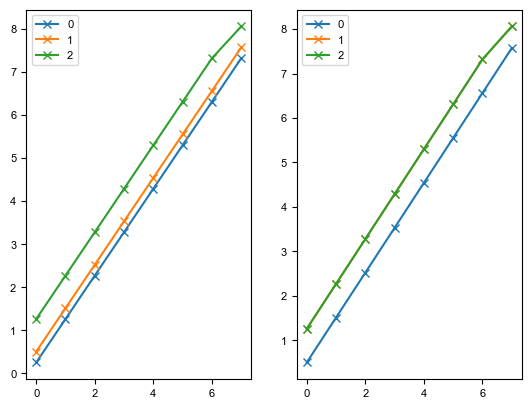

In [9]:
# ordered visual stimulation configuration (only works for one repetition)
ideal_static_moving_t_s = np.array([0.25, 0.75, 0]) # updated blank and stimulation calculation time stamps
# ideal_static_moving_t_s = np.array([0.25, 0.5, 0.25])

# correct timing from statistical analysis of the record result
static_moving_t_s = ideal_static_moving_t_s

nof_orient = 8

orient_angles_deg = np.arange(nof_orient) * (360/nof_orient)
orient_angles_rad = orient_angles_deg * (np.pi/180)
 
print(orient_angles_deg)

# conversion
nof_stim_steps = static_moving_t_s.size
tot_trail_t_s = np.sum(static_moving_t_s)

stim_tstamp_s = np.zeros((nof_orient, nof_stim_steps, 2))

cur_start_t_s = np.arange(nof_orient) * tot_trail_t_s
for i_step in range(nof_stim_steps):
    stim_tstamp_s[:, i_step, 0] = cur_start_t_s
    cur_start_t_s = cur_start_t_s + static_moving_t_s[i_step]
    stim_tstamp_s[:, i_step, 1] = cur_start_t_s

print(tot_trail_t_s)
print(stim_tstamp_s.shape)

stim_tstamp_s = 0.25 + stim_tstamp_s # updated blank and stimulation calculation time stamps

stim_tstamp_s = stim_tstamp_s * real_timing_correct_ratio

stim_tstamp_s[stim_tstamp_s > (3100-1)*time_per_frame_ms*1E-3] = (3100-1)*time_per_frame_ms*1E-3 # updated blank and stimulation calculation time stamps

plt.figure()
for i in range(2):
    plt.subplot(1,2,i + 1)
    for i_step in range(nof_stim_steps):
        plt.plot(stim_tstamp_s[:,i_step,i], "-x", label = f"{i_step}")
    plt.legend()
    
stim_tstamp = (stim_tstamp_s * s_to_ms)/time_per_frame_ms
stim_tstamp = stim_tstamp.astype(int)
    
SAVE_PROGRESS(HISTORY_FILEPATH)

In [10]:
# source configurations
src_root_dir = r"M:\2023-05-11\M347\FOV02\Group01"
src_sub_dir_name = r"VolpyResults_Ver01p6_NewMasNewkMC_STD5"
src_hdf5_file_name = r"results.hdf5"

dst_root_dir = src_root_dir
dst_dir_name = "StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming"
dst_plot_sub_dir_name = "Plots"

t_test_alpha = 0.05
anova_test_alpha = 0.05

valid_dFF_lim = np.array([-5, 5])

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 21.31 s


In [11]:
# generate package name list 
src_pkg_names = listPkgNames(src_root_dir)
src_pkg_names = sortPkgNames(src_pkg_names)
print(src_pkg_names)

SAVE_PROGRESS(HISTORY_FILEPATH)

['Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F0_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F1_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F2_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F3_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F4_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F5_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F6_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F7_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F8_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F9_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F10_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F11_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F12_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F13_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F14_Pkg'
 'Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F15_Pkg']
Time since last sync = 21.32 s


In [12]:
# load spike event information
NFRAMES_KEY = "roi0\\volpy_estimates\\dFF"
roi_regex = r"roi\d+"

fields = [
    "roi{iroi:d}\\stdThreshold\\spikes_invalid",
    "roi{iroi:d}\\stdThreshold\\spikes_valid",
    "roi{iroi:d}\\volpy_estimates\\spikes",
]

dFF_key = "roi{iroi:d}\\volpy_estimates\\dFF"
snr_key =  "roi{iroi:d}\\volpy_estimates\\snr"
raw_dFF_key = "roi{iroi:d}\\volpy_estimates\\rawROI\\dFF"
F0_key = "roi{iroi:d}\\volpy_estimates\\F0"
t_key = "roi{iroi:d}\\volpy_estimates\\t"
raw_t_key = "roi{iroi:d}\\volpy_estimates\\rawROI\\t"

nof_fields = len(fields)
nof_roi = 0
nof_files = len(src_pkg_names)
nof_frames = 0

spike_events = None

#preprocess
for ipkg_name in [src_pkg_names[0]]:
    src_hdf5_file_path = os.path.join(src_root_dir, ipkg_name, src_sub_dir_name, src_hdf5_file_name)
    with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
        # print(hdf5_file.keys())
        # nof_frames = hdf5_file[NFRAMES_KEY].value.shape[0]
        # print(hdf5_file[NFRAMES_KEY].value.shape)
        nof_frames = hdf5_file[NFRAMES_KEY][()].shape[0]
        print(hdf5_file[NFRAMES_KEY][()].shape)
#         print(hdf5_file.keys()) # debug
        max_roi_num = 0
        for key in hdf5_file.keys():
            for istr in re.findall(roi_regex, key):
                cur_roi_num = int(istr[3:])
                max_roi_num = max(max_roi_num, cur_roi_num)
        nof_roi = max_roi_num + 1
        
spike_events = np.zeros((nof_roi, nof_fields, nof_files, nof_frames))
dFFs = np.zeros((nof_roi, nof_files, nof_frames))
raw_dFFs = np.zeros((nof_roi, nof_files, nof_frames))
F0 = np.zeros((nof_roi, nof_files, nof_frames))
snrs = np.zeros((nof_roi, nof_files))
t = np.zeros((nof_roi, nof_files, nof_frames))
raw_t = np.zeros((nof_roi, nof_files, nof_frames))


for ifile in range(nof_files):
    src_hdf5_file_path = os.path.join(src_root_dir, src_pkg_names[ifile], src_sub_dir_name, src_hdf5_file_name)
    # print(src_hdf5_file_path)
    with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
        for iroi in range(nof_roi):
            for ifield in range(nof_fields):
                # spike_idxs = hdf5_file[fields[ifield].format(iroi = iroi)].value
                spike_idxs = hdf5_file[fields[ifield].format(iroi = iroi)][()]

#                 print(spike_idxs)
                spike_events[iroi, ifield, ifile, spike_idxs] = 1
            # dFFs[iroi, ifile, :] = hdf5_file[dFF_key.format(iroi = iroi)].value
            dFFs[iroi, ifile, :] = hdf5_file[dFF_key.format(iroi = iroi)][()]
            raw_dFFs[iroi, ifile, :] = hdf5_file[raw_dFF_key.format(iroi = iroi)][()]
            F0[iroi, ifile, :] = hdf5_file[F0_key.format(iroi = iroi)][()]
            snrs[iroi, ifile] =  hdf5_file[snr_key.format(iroi = iroi)][()]
            t[iroi, ifile, :] = hdf5_file[t_key.format(iroi = iroi)][()]
            raw_t[iroi, ifile, :] = hdf5_file[raw_t_key.format(iroi = iroi)][()]

SAVE_PROGRESS(HISTORY_FILEPATH)

(3100,)
Time since last sync = 25.00 s


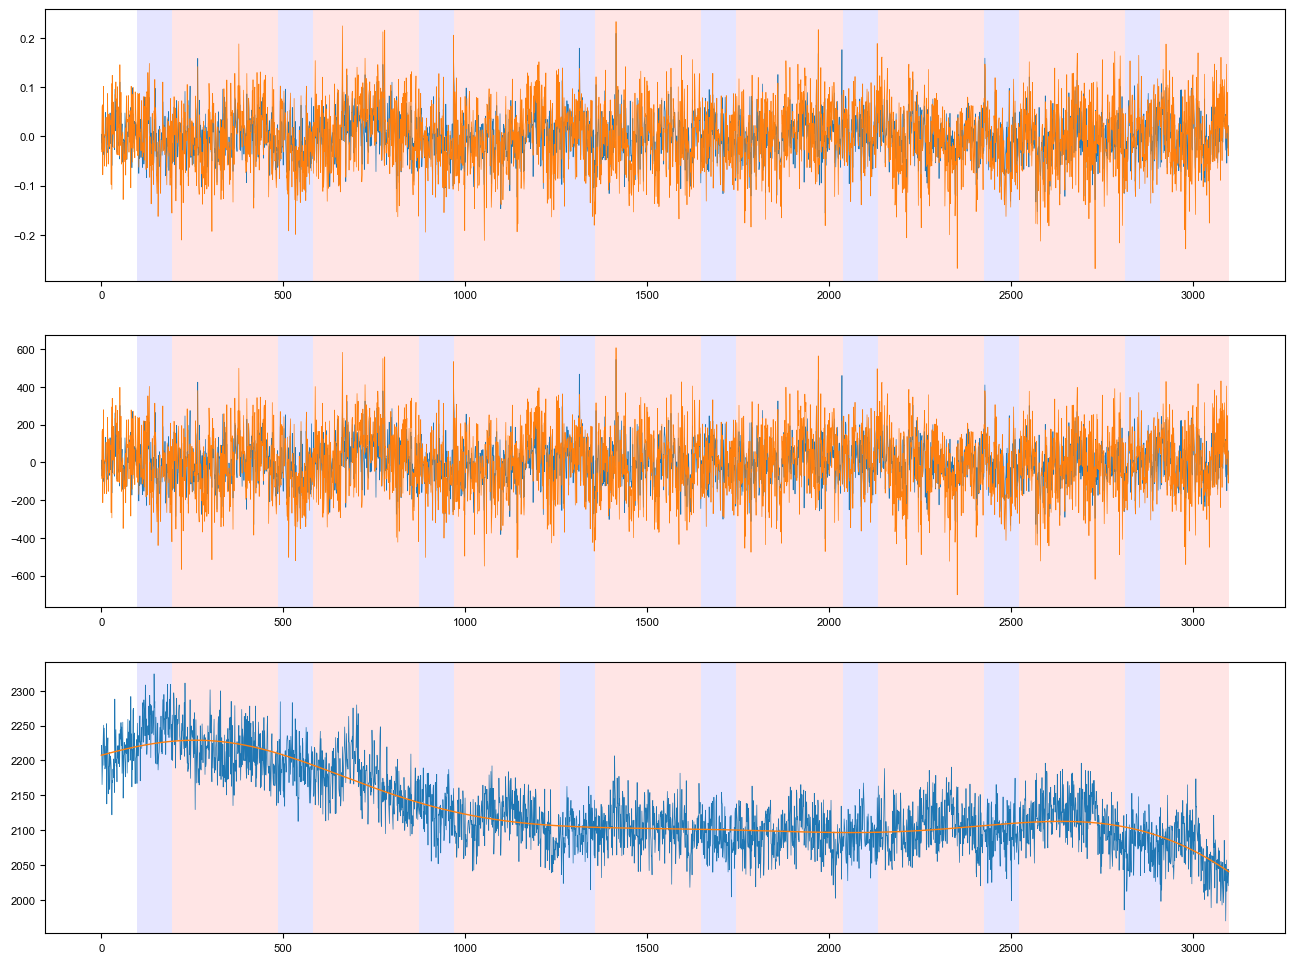

Time since last sync = 25.66 s


In [13]:
preview_i_roi = 0
preview_i_trial = 1

plt.figure(figsize = (16, 12))
plt.subplot(3,1,1)
plt.plot(dFFs[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
plt.plot(raw_dFFs[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
stim_time_stamp_axvspan(stim_tstamp)
plt.subplot(3,1,2)
plt.plot(t[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
plt.plot(raw_t[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
# plt.plot(F0[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
stim_time_stamp_axvspan(stim_tstamp)
plt.subplot(3,1,3)
# plt.plot((t + F0)[preview_i_roi,preview_i_trial,:], linewidth = 0.5)
# plt.plot(F0[preview_i_roi,preview_i_trial,:], linewidth = 1)
plt.plot(np.mean((t + F0)[preview_i_roi, :, :], axis = 0), linewidth = 0.5)
plt.plot(np.mean(F0[preview_i_roi, :, :], axis = 0), linewidth = 1)
stim_time_stamp_axvspan(stim_tstamp)
plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

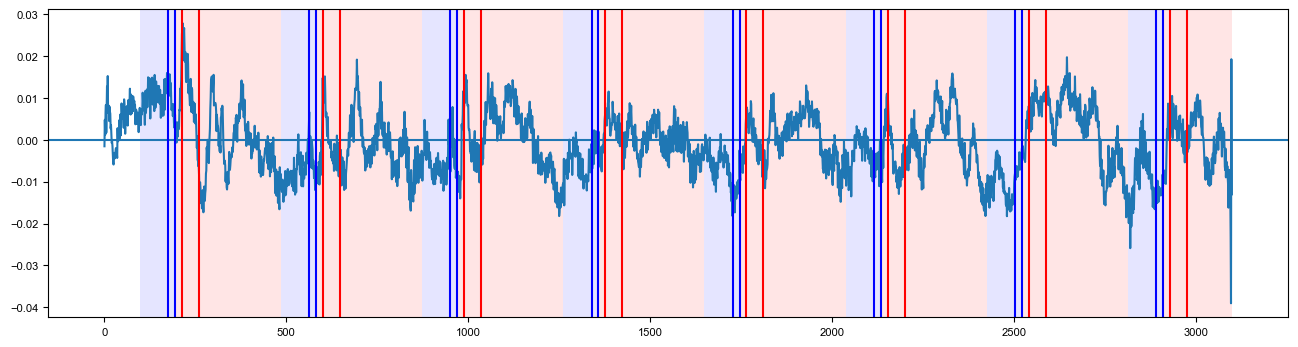

In [14]:
# configure epsp period for subthreshold dF/F calculation

epsp_period_len_ms = 120
epsp_offset_ms = 50 * np.ones((8,))

# epsp_period_len_ms = 150
# epsp_offset_ms = np.array([70, 50, 70, 80, 100, 100, 100, 100])
# epsp_offset_ms = np.zeros((8,))

epsp_pre_blanck_len_ms = 50

epsp_period_len_frames = int(np.round(epsp_period_len_ms/time_per_frame_ms))
epsp_pre_blank_len_frames = int(np.round(epsp_pre_blanck_len_ms/time_per_frame_ms))
epsp_offset_frames = np.round(epsp_offset_ms/time_per_frame_ms).astype(int)

epsp_tstamp = stim_tstamp.copy()
epsp_tstamp[:,1,:] = epsp_tstamp[:,1,:] + epsp_offset_frames[:, np.newaxis]
epsp_tstamp[:,1,1] = epsp_tstamp[:,1,0] + epsp_period_len_frames
epsp_tstamp[:,0,0] = epsp_tstamp[:,0,1] - epsp_pre_blank_len_frames

nof_orients, nof_steps, nof_pnts = stim_tstamp.shape

for i_orient in range(nof_orients):
    cur_epsp_start_times = epsp_tstamp[i_orient,:,0]
    cur_stim_start_times = stim_tstamp[i_orient,:,0]
    # print(cur_epsp_start_times.shape)
    # print(cur_stim_start_times.shape)
    cur_epsp_start_times[cur_epsp_start_times < cur_stim_start_times] = cur_stim_start_times[cur_epsp_start_times < cur_stim_start_times] 
    cur_epsp_end_times = epsp_tstamp[i_orient,:,1]
    cur_stim_end_times = stim_tstamp[i_orient,:,1]
    cur_epsp_end_times[cur_epsp_end_times > cur_stim_end_times] = cur_stim_end_times[cur_epsp_end_times > cur_stim_end_times]


plt.figure(figsize = (16,4))
plt.plot(np.mean(dFFs, axis = (0,1)))
plt.axhline(0)
stim_time_stamp_axvspan(stim_tstamp)
stim_time_stamp_axvline(epsp_tstamp)
plt.show()

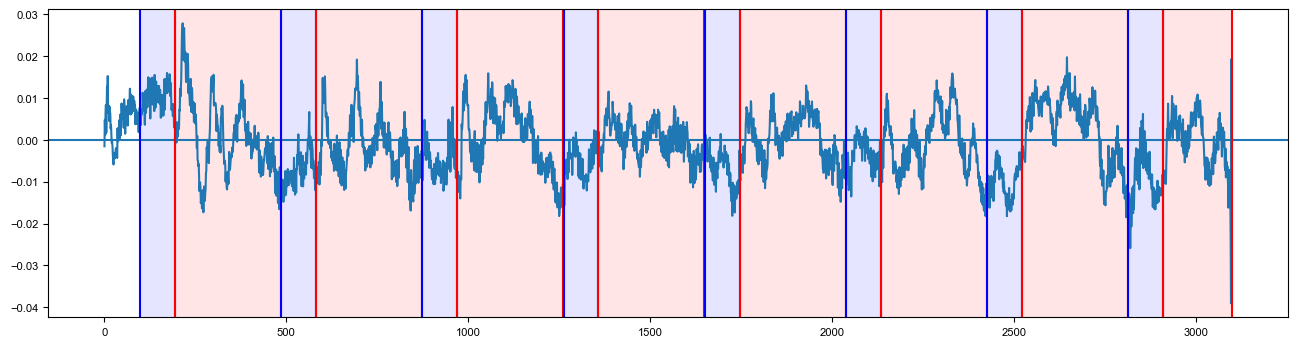

In [15]:
# configure epsp period for subthreshold dF/F calculation

eva_pre_blanck_len_ms = 250
# eva_pre_blanck_len_ms = 50

eva_pre_blank_len_frames = int(np.round(eva_pre_blanck_len_ms/time_per_frame_ms))

eva_tstamp = stim_tstamp.copy()
eva_tstamp[:,0,0] = eva_tstamp[:,0,1] - eva_pre_blank_len_frames

nof_orients, nof_steps, nof_pnts = stim_tstamp.shape

for i_orient in range(nof_orients):
    cur_eva_start_times = eva_tstamp[i_orient,:,0]
    cur_stim_start_times = stim_tstamp[i_orient,:,0]
    # print(cur_epsp_start_times.shape)
    # print(cur_stim_start_times.shape)
    cur_eva_start_times[cur_eva_start_times < cur_stim_start_times] = cur_stim_start_times[cur_eva_start_times < cur_stim_start_times] 
    cur_eva_end_times = eva_tstamp[i_orient,:,1]
    cur_stim_end_times = stim_tstamp[i_orient,:,1]
    cur_eva_end_times[cur_eva_end_times > cur_stim_end_times] = cur_stim_end_times[cur_eva_end_times > cur_stim_end_times]


plt.figure(figsize = (16,4))
plt.plot(np.mean(dFFs, axis = (0,1)))
plt.axhline(0)
stim_time_stamp_axvspan(stim_tstamp)
stim_time_stamp_axvline(eva_tstamp)
plt.show()

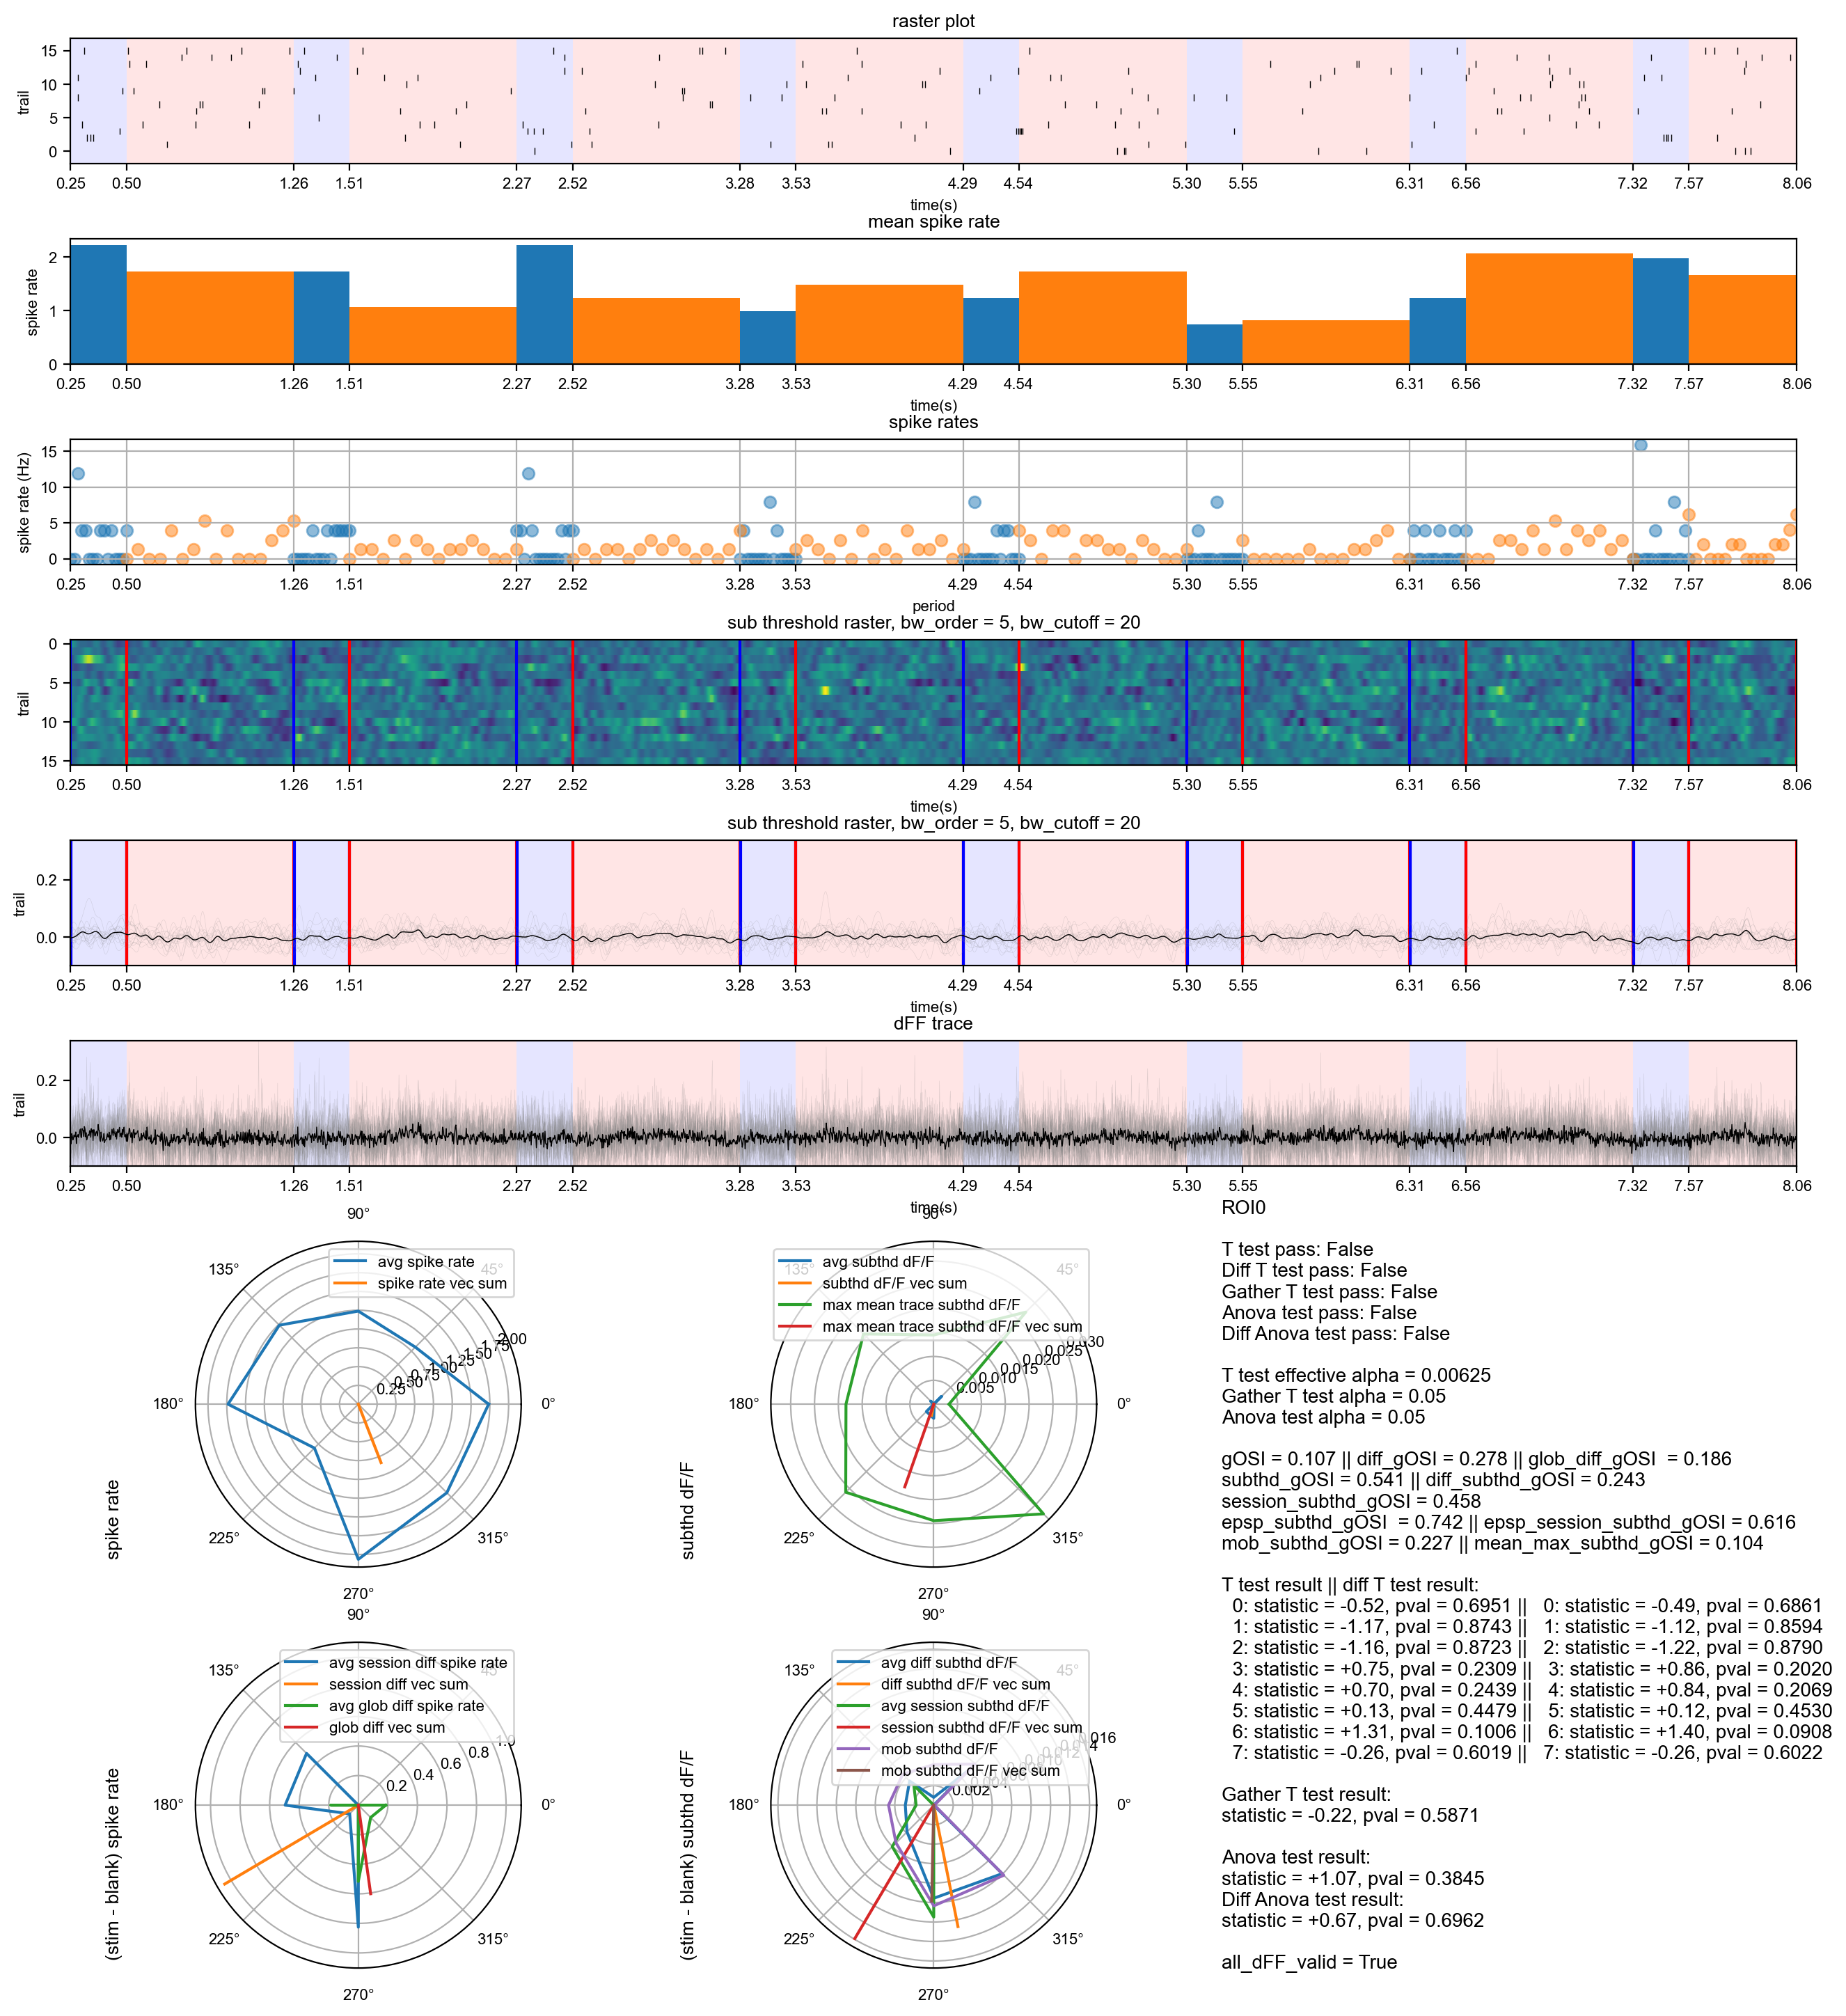

{'i_roi': 0, 'fs': 384.6153846153846, 'bw_order': 5, 'bw_cutoff': 20, 'stim_tstamp': array([[[  97,  194],
        [ 194,  485],
        [ 485,  485]],

       [[ 485,  582],
        [ 582,  873],
        [ 873,  873]],

       [[ 873,  970],
        [ 970, 1261],
        [1261, 1261]],

       [[1261, 1358],
        [1358, 1649],
        [1649, 1649]],

       [[1649, 1746],
        [1746, 2038],
        [2038, 2038]],

       [[2038, 2135],
        [2135, 2426],
        [2426, 2426]],

       [[2426, 2523],
        [2523, 2814],
        [2814, 2814]],

       [[2814, 2911],
        [2911, 3099],
        [3099, 3099]]]), 'stim_tstamp_s': array([[[0.252325, 0.50465 ],
        [0.50465 , 1.261625],
        [1.261625, 1.261625]],

       [[1.261625, 1.51395 ],
        [1.51395 , 2.270925],
        [2.270925, 2.270925]],

       [[2.270925, 2.52325 ],
        [2.52325 , 3.280225],
        [3.280225, 3.280225]],

       [[3.280225, 3.53255 ],
        [3.53255 , 4.289525],
        [4.289525

In [16]:
preview_i_roi = 0
preview_i_field = 1

spike_event = spike_events[preview_i_roi, preview_i_field, :, :]
dFF = dFFs[preview_i_roi, :, :]
cur_F0 = F0[preview_i_roi, :, :]

result_summary = stats_analysis(
    preview_i_roi,
    spike_event,
    dFF,
    cur_F0,
    bw_order,
    bw_cutoff,
    fs,
    stim_tstamp,
    stim_tstamp_s,
    epsp_tstamp,
    eva_tstamp,
    orient_angles_rad,
    t_test_alpha,
    anova_test_alpha,
    valid_dFF_lim,
    dst_dir_path = ".",
    process_mode = "show",
)

#print(result_summary)

SAVE_PROGRESS(HISTORY_FILEPATH)

In [21]:
# batch processing
process_field = 1 

nof_roi = spike_events.shape[0]
nof_traces = spike_events.shape[2]
trace_len = spike_events.shape[3]
nof_orints = orient_angles_rad.shape[0]

dst_dir_path = os.path.join(dst_root_dir, dst_dir_name)
dst_plot_sub_dir_path = os.path.join(dst_dir_path, dst_plot_sub_dir_name)

if not os.path.isdir(dst_dir_path):
    os.makedirs(dst_dir_path)
    
if not os.path.isdir(dst_plot_sub_dir_path):
    os.makedirs(dst_plot_sub_dir_path)
    
result_summarys = []
for i_roi in range(nof_roi):
    
    spike_event = spike_events[i_roi, process_field, :, :]
    dFF = dFFs[i_roi, :, :]
    cur_F0 = F0[i_roi, :, :]

    result_summary = stats_analysis(
        i_roi,
        spike_event,
        dFF,
        cur_F0,
        bw_order,
        bw_cutoff,
        fs,
        stim_tstamp,
        stim_tstamp_s,
        epsp_tstamp,
        eva_tstamp,
        orient_angles_rad,
        t_test_alpha,
        anova_test_alpha,
        valid_dFF_lim,
        dst_dir_path = dst_plot_sub_dir_path,
        process_mode = "save",
        # process_mode = "none",
    )
    
    result_summarys.append(result_summary)

SAVE_PROGRESS(HISTORY_FILEPATH)

C:\Users\zhong\AppData\Local\Temp\ipykernel_15832\485055196.py:61: RuntimeWarning: invalid value encountered in scalar divide
  gOSI = np.abs(np.sum( responses * np.exp(2.0j * orientations) )) / np.sum(responses)


Progress saved to: \\10.254.8.27\jilab2\Jian\BackUp\JupyterNotebookRemoteBackup\JEDI2PStatsAnalysisBathSubthresholdVer06_2024-02-29.py


In [22]:
# save results to hdf5 file
dst_hdf5_file_name = "stats_analysis_data.hdf5"
dst_hdf5_file_path = os.path.join(dst_dir_path, dst_hdf5_file_name)

dst_dir_path = os.path.join(dst_root_dir, dst_dir_name)
print(dst_dir_path)

if not os.path.isdir(dst_dir_path):
    os.makedirs(dst_dir_path)

with h5py.File(dst_hdf5_file_path, "w") as hdf5_file:
    # hdf5_file.create_dataset("src_root_dir", data = src_root_dir.encode("ascii", "ignore"))
    # hdf5_file.create_dataset("src_sub_dir_name", data = src_sub_dir_name.encode("ascii", "ignore"))
    # hdf5_file.create_dataset("src_hdf5_file_name", data = src_hdf5_file_name.encode("ascii", "ignore"))
    # hdf5_file.create_dataset("src_pkg_names", 
    #                          (len(src_pkg_names), 1), 
    #                          "S10",
    #                          [n.encode("ascii","ignore") for n in src_pkg_names],
    #                         )
    hdf5_file.create_dataset("time_per_frame_ms", data = time_per_frame_ms)
    hdf5_file.create_dataset("ms_to_s", data = ms_to_s)
    hdf5_file.create_dataset("s_to_ms", data = s_to_ms)
    hdf5_file.create_dataset("bw_order", data = bw_order)
    hdf5_file.create_dataset("bw_cutoff", data = bw_cutoff)
    hdf5_file.create_dataset("fs", data = fs)
    hdf5_file.create_dataset("static_moving_t_s", data = static_moving_t_s)
    hdf5_file.create_dataset("nof_orient", data = nof_orient)
    hdf5_file.create_dataset("orient_angles_deg", data = orient_angles_deg)
    hdf5_file.create_dataset("orient_angles_rad", data = orient_angles_rad)
    hdf5_file.create_dataset("stim_tstamp_s", data = stim_tstamp_s)
    hdf5_file.create_dataset("stim_tstamp", data = stim_tstamp)
    hdf5_file.create_dataset("src_root_dir", data = src_root_dir)
    hdf5_file.create_dataset("src_sub_dir_name", data = src_sub_dir_name)
    hdf5_file.create_dataset("src_hdf5_file_name", data = src_hdf5_file_name)
    for i_str in range(len(src_pkg_names)):
        hdf5_file.create_dataset(f"src_pkg_names[{i_str}]", data = src_pkg_names.tolist()[i_str])
    hdf5_file.create_dataset("NFRAMES_KEY", data = NFRAMES_KEY)
    for i_str in range(len(fields)):
        hdf5_file.create_dataset(f"fields[{i_str}]", data = fields[i_str])
    hdf5_file.create_dataset("nof_fields", data = nof_fields)
    hdf5_file.create_dataset("nof_roi", data = nof_roi)
    hdf5_file.create_dataset("nof_files", data = nof_files)
    hdf5_file.create_dataset("nof_frames", data = nof_frames)
    hdf5_file.create_dataset("spike_events", data = spike_events)
    hdf5_file.create_dataset("dFFs", data = dFFs)
    hdf5_file.create_dataset("snrs", data = snrs)
    hdf5_file.create_dataset("raw_dFFs", data = raw_dFFs)
    hdf5_file.create_dataset("F0", data = F0)
    hdf5_file.create_dataset("t", data = t)
    hdf5_file.create_dataset("raw_t", data = raw_t)
    hdf5_file.create_dataset("process_field", data = process_field)
    hdf5_file.create_dataset("epsp_period_len_ms", data = epsp_period_len_ms)
    hdf5_file.create_dataset("epsp_period_len_frames", data = epsp_period_len_frames)
    hdf5_file.create_dataset("epsp_offset_ms", data = epsp_offset_ms)
    hdf5_file.create_dataset("epsp_offset_frames", data = epsp_offset_frames)
    hdf5_file.create_dataset("epsp_tstamp", data = epsp_tstamp)
    hdf5_file.create_dataset("eva_pre_blanck_len_ms", data = eva_pre_blanck_len_ms)
    hdf5_file.create_dataset("eva_pre_blank_len_frames", data = eva_pre_blank_len_frames)
    hdf5_file.create_dataset("eva_tstamp", data = eva_tstamp)
    hdf5_file.create_dataset("real_period_s", data = real_period_s)
    hdf5_file.create_dataset("ideal_period_s", data = ideal_period_s)
    hdf5_file.create_dataset("real_timing_correct_ratio", data = real_timing_correct_ratio)
    hdf5_file.create_dataset("ideal_static_moving_t_s", data = ideal_static_moving_t_s)
    hdf5_file.create_dataset("valid_dFF_lim", data = valid_dFF_lim)
    
    stats_result_tage = "stats_result"
    for i_roi in range(nof_roi):
        if i_roi%10 == 0:
            print(f"Saving ROI{i_roi}...")
            
        cur_result = result_summarys[i_roi]
        roi_num = cur_result["i_roi"]
        roi_name = f"roi{roi_num}"
        dirct_save_keys = [
            "cur_spike_event",
            "cur_spike_cnts",
            "cur_spike_rate",
            "t_test_pvals",
            "t_test_effective_alpha",
            "t_test_alpha",
            "anova_test_alpha",
            "t_test_pass",
            "diff_t_test_pass",
            "gather_t_test_pass",
            "anova_test_pass",
            "diff_anova_test_pass",
            "responses",
            "diff_responses",
            "gOSI",
            "diff_gOSI",
            "fs",
            "bw_order",
            "bw_cutoff",
            "cur_dFF",
            "cur_subthreshold_dFF",
            "diff_t_test_pvals",
            "cur_subthd_dFF_means",
            "subthd_responses",
            "subthd_gOSI",
            "diff_subthd_responses",
            "diff_subthd_gOSI",
            "cur_F0",
            "cur_subthreshold_F",
            "cur_subthd_F_means",
            "cur_subthd_dF_means",
            "cur_subthd_F0_means",
            "session_subthd_responses",
            "session_subthd_gOSI",
            "glob_diff_responses",
            "glob_diff_gOSI",
            "stim_tstamp",
            "stim_tstamp_s",
            "epsp_tstamp",
            "cur_epsp_subthd_dFF_means",
            "epsp_subthd_responses",
            "epsp_subthd_gOSI",
            "cur_epsp_subthd_F_means",
            "epsp_session_subthd_responses",
            "epsp_session_subthd_gOSI",
            "fft_subthd_responses",
            "fft_responses",
            "eva_tstamp",
            "cur_eva_subthd_dFF_means",
            "mean_subthd_F_max",
            "mean_subthd_dF_max",
            "mean_subthd_dFF_max",
            "mob_subthd_responses",
            "mob_subthd_gOSI",
            "mean_max_subthd_responses",
            "mean_max_subthd_gOSI",
            "valid_dFF_lim",
            "valid_dFF_trace_mask",
            "all_dFF_valid",
        ]
        
        for key in dirct_save_keys:
            hdf5_save_key = os.path.join(roi_name, key)
            hdf5_file.create_dataset(hdf5_save_key, data = cur_result[key])
        
        vec_sum_hdf5_save_key = os.path.join(roi_name, "vec_sum_complex")
        hdf5_file.create_dataset(vec_sum_hdf5_save_key, data = cur_result["vec_sum_complex"])
        hdf5_file.create_dataset(vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["vec_sum_complex"]))
        hdf5_file.create_dataset(vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["vec_sum_complex"]))

        diff_vec_sum_hdf5_save_key = os.path.join(roi_name, "diff_vec_sum_complex")
        hdf5_file.create_dataset(diff_vec_sum_hdf5_save_key, data = cur_result["diff_vec_sum_complex"])
        hdf5_file.create_dataset(diff_vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["diff_vec_sum_complex"]))
        hdf5_file.create_dataset(diff_vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["diff_vec_sum_complex"]))

        glob_diff_vec_sum_hdf5_save_key = os.path.join(roi_name, "glob_diff_vec_sum_complex")
        hdf5_file.create_dataset(glob_diff_vec_sum_hdf5_save_key, data = cur_result["glob_diff_vec_sum_complex"])
        hdf5_file.create_dataset(glob_diff_vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["glob_diff_vec_sum_complex"]))
        hdf5_file.create_dataset(glob_diff_vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["glob_diff_vec_sum_complex"]))

        subthd_vec_sum_hdf5_save_key = os.path.join(roi_name, "subthd_vec_sum_complex")
        hdf5_file.create_dataset(subthd_vec_sum_hdf5_save_key, data = cur_result["subthd_vec_sum_complex"])
        hdf5_file.create_dataset(subthd_vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["subthd_vec_sum_complex"]))
        hdf5_file.create_dataset(subthd_vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["subthd_vec_sum_complex"]))

        epsp_subthd_vec_sum_hdf5_save_key = os.path.join(roi_name, "epsp_subthd_vec_sum_complex")
        hdf5_file.create_dataset(epsp_subthd_vec_sum_hdf5_save_key, data = cur_result["epsp_subthd_vec_sum_complex"])
        hdf5_file.create_dataset(epsp_subthd_vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["epsp_subthd_vec_sum_complex"]))
        hdf5_file.create_dataset(epsp_subthd_vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["epsp_subthd_vec_sum_complex"]))

        diff_subthd_vec_sum_hdf5_save_key = os.path.join(roi_name, "diff_subthd_vec_sum_complex")
        hdf5_file.create_dataset(diff_subthd_vec_sum_hdf5_save_key, data = cur_result["diff_subthd_vec_sum_complex"])
        hdf5_file.create_dataset(diff_subthd_vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["diff_subthd_vec_sum_complex"]))
        hdf5_file.create_dataset(diff_subthd_vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["diff_subthd_vec_sum_complex"]))

        session_vec_sum_hdf5_save_key = os.path.join(roi_name, "session_subthd_vec_sum_complex")
        hdf5_file.create_dataset(session_vec_sum_hdf5_save_key, data = cur_result["session_subthd_vec_sum_complex"])
        hdf5_file.create_dataset(session_vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["session_subthd_vec_sum_complex"]))
        hdf5_file.create_dataset(session_vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["session_subthd_vec_sum_complex"]))

        epsp_session_vec_sum_hdf5_save_key = os.path.join(roi_name, "epsp_session_subthd_vec_sum_complex")
        hdf5_file.create_dataset(epsp_session_vec_sum_hdf5_save_key, data = cur_result["epsp_session_subthd_vec_sum_complex"])
        hdf5_file.create_dataset(epsp_session_vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["epsp_session_subthd_vec_sum_complex"]))
        hdf5_file.create_dataset(epsp_session_vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["epsp_session_subthd_vec_sum_complex"]))

        gather_t_test_result_hdf5_save_key = os.path.join(roi_name, "gather_t_test_result")
        hdf5_file.create_dataset(gather_t_test_result_hdf5_save_key + ".statistic", 
                                 data = cur_result["gather_t_test_result"].statistic)
        hdf5_file.create_dataset(gather_t_test_result_hdf5_save_key +".pvalue",
                                data = cur_result["gather_t_test_result"].pvalue)
        
        anova_test_result_hdf5_save_key = os.path.join(roi_name, "anova_test_result")
        hdf5_file.create_dataset(anova_test_result_hdf5_save_key + ".statistic", 
                                 data = cur_result["anova_test_result"].statistic)
        hdf5_file.create_dataset(anova_test_result_hdf5_save_key +".pvalue",
                                data = cur_result["anova_test_result"].pvalue)

        diff_anova_test_result_hdf5_save_key = os.path.join(roi_name, "diff_anova_test_result")
        hdf5_file.create_dataset(diff_anova_test_result_hdf5_save_key + ".statistic", 
                                 data = cur_result["diff_anova_test_result"].statistic)
        hdf5_file.create_dataset(diff_anova_test_result_hdf5_save_key +".pvalue",
                                data = cur_result["diff_anova_test_result"].pvalue)

        mob_subthd_vec_sum_hdf5_save_key = os.path.join(roi_name, "mob_subthd_vec_sum_complex")
        hdf5_file.create_dataset(mob_subthd_vec_sum_hdf5_save_key, data = cur_result["mob_subthd_vec_sum_complex"])
        hdf5_file.create_dataset(mob_subthd_vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["mob_subthd_vec_sum_complex"]))
        hdf5_file.create_dataset(mob_subthd_vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["mob_subthd_vec_sum_complex"]))

        mean_max_subthd_vec_sum_hdf5_save_key = os.path.join(roi_name, "mean_max_subthd_vec_sum_complex")
        hdf5_file.create_dataset(mean_max_subthd_vec_sum_hdf5_save_key, data = cur_result["mean_max_subthd_vec_sum_complex"])
        hdf5_file.create_dataset(mean_max_subthd_vec_sum_hdf5_save_key + ".amp", 
                                 data = np.abs(cur_result["mean_max_subthd_vec_sum_complex"]))
        hdf5_file.create_dataset(mean_max_subthd_vec_sum_hdf5_save_key + ".ang", 
                                 data = np.angle(cur_result["mean_max_subthd_vec_sum_complex"]))

        
        t_test_results_hdf5_save_key = os.path.join(roi_name, "t_test_results")
        for i_test_res in range(len(cur_result["t_test_results"])):
            hdf5_file.create_dataset(t_test_results_hdf5_save_key + f"[{i_test_res}].statistic",
                                    data = cur_result["t_test_results"][i_test_res].statistic)
            hdf5_file.create_dataset(t_test_results_hdf5_save_key + f"[{i_test_res}].pvalue",
                                    data = cur_result["t_test_results"][i_test_res].pvalue)
            
        diff_t_test_results_hdf5_save_key = os.path.join(roi_name, "diff_t_test_results")
        for i_test_res in range(len(cur_result["diff_t_test_results"])):
            hdf5_file.create_dataset(diff_t_test_results_hdf5_save_key + f"[{i_test_res}].statistic",
                                    data = cur_result["diff_t_test_results"][i_test_res].statistic)
            hdf5_file.create_dataset(diff_t_test_results_hdf5_save_key + f"[{i_test_res}].pvalue",
                                    data = cur_result["diff_t_test_results"][i_test_res].pvalue)
            
print("result hdf5 file saved to: " + dst_hdf5_file_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming
Saving ROI0...
Saving ROI10...
Saving ROI20...
Saving ROI30...
Saving ROI40...
Saving ROI50...
Saving ROI60...
Saving ROI70...
Saving ROI80...
Saving ROI90...
Saving ROI100...
Saving ROI110...
Saving ROI120...
Saving ROI130...
Saving ROI140...
Saving ROI150...
result hdf5 file saved to: M:\2023-05-11\M347\FOV02\Group01\StatsAnalysisSubtresholds_Ver06_FromVer01p6_20Hz5OrderBW_CorrectMeanTiming\stats_analysis_data.hdf5
Time since last sync = 25.99 s


In [23]:
for ifile in range(1):
    src_hdf5_file_path = os.path.join(src_root_dir, src_pkg_names[ifile], src_sub_dir_name, src_hdf5_file_name)
    print(src_hdf5_file_path)
    with h5py.File(src_hdf5_file_path, "r") as hdf5_file:
        print(hdf5_file.keys())

M:\2023-05-11\M347\FOV02\Group01\Olympus25X_M347_FOV02_Group01_TS_CH0_CHA_F0_Pkg\VolpyResults_Ver01p6_NewMasNewkMC_STD5\results.hdf5
<KeysViewHDF5 ['roi0\\stdThreshold\\spikes_invalid', 'roi0\\stdThreshold\\spikes_valid', 'roi0\\volpy_estimates\\F0', 'roi0\\volpy_estimates\\cell_n', 'roi0\\volpy_estimates\\context_coord', 'roi0\\volpy_estimates\\dFF', 'roi0\\volpy_estimates\\locality', 'roi0\\volpy_estimates\\low_spikes', 'roi0\\volpy_estimates\\mean_im', 'roi0\\volpy_estimates\\num_spikes', 'roi0\\volpy_estimates\\rawROI\\dFF', 'roi0\\volpy_estimates\\rawROI\\spikes', 'roi0\\volpy_estimates\\rawROI\\t', 'roi0\\volpy_estimates\\rawROI\\templates', 'roi0\\volpy_estimates\\rawROI\\ts', 'roi0\\volpy_estimates\\rawROI\\weights', 'roi0\\volpy_estimates\\snr', 'roi0\\volpy_estimates\\spikes', 'roi0\\volpy_estimates\\t', 'roi0\\volpy_estimates\\t_rec', 'roi0\\volpy_estimates\\t_sub', 'roi0\\volpy_estimates\\templates', 'roi0\\volpy_estimates\\thresh', 'roi0\\volpy_estimates\\ts', 'roi0\\volpy

In [20]:
with h5py.File(dst_hdf5_file_path, "r") as hdf5_file:
    print(hdf5_file.keys())

<KeysViewHDF5 ['F0', 'NFRAMES_KEY', 'bw_cutoff', 'bw_order', 'dFFs', 'epsp_offset_frames', 'epsp_offset_ms', 'epsp_period_len_frames', 'epsp_period_len_ms', 'epsp_tstamp', 'eva_pre_blanck_len_ms', 'eva_pre_blank_len_frames', 'eva_tstamp', 'fields[0]', 'fields[1]', 'fields[2]', 'fs', 'ideal_period_s', 'ideal_static_moving_t_s', 'ms_to_s', 'nof_fields', 'nof_files', 'nof_frames', 'nof_orient', 'nof_roi', 'orient_angles_deg', 'orient_angles_rad', 'process_field', 'raw_dFFs', 'raw_t', 'real_period_s', 'real_timing_correct_ratio', 'roi0\\all_dFF_valid', 'roi0\\anova_test_alpha', 'roi0\\anova_test_pass', 'roi0\\anova_test_result.pvalue', 'roi0\\anova_test_result.statistic', 'roi0\\bw_cutoff', 'roi0\\bw_order', 'roi0\\cur_F0', 'roi0\\cur_dFF', 'roi0\\cur_epsp_subthd_F_means', 'roi0\\cur_epsp_subthd_dFF_means', 'roi0\\cur_eva_subthd_dFF_means', 'roi0\\cur_spike_cnts', 'roi0\\cur_spike_event', 'roi0\\cur_spike_rate', 'roi0\\cur_subthd_F0_means', 'roi0\\cur_subthd_F_means', 'roi0\\cur_subthd_dFF